In [170]:
%env QXToken=5cd4fb14ed1e310399096fe9bd62d528d5999de11ad231bf5e0ca742f7a4e3dd0960a5ddcde760edfbda609b5411e036f45965998ec4993e6336d7b2ed414701
%env QC_GRADING_ENDPOINT=https://qac-grading.quantum-computing.ibm.com
%env QXAuthURL=https://auth.quantum-computing.ibm.com/api


env: QXToken=5cd4fb14ed1e310399096fe9bd62d528d5999de11ad231bf5e0ca742f7a4e3dd0960a5ddcde760edfbda609b5411e036f45965998ec4993e6336d7b2ed414701
env: QC_GRADING_ENDPOINT=https://qac-grading.quantum-computing.ibm.com
env: QXAuthURL=https://auth.quantum-computing.ibm.com/api


In [171]:
import os
# verify enviroment setting
print((os.environ['QXToken'],
os.environ['QC_GRADING_ENDPOINT'],
os.environ['QXAuthURL']))

('5cd4fb14ed1e310399096fe9bd62d528d5999de11ad231bf5e0ca742f7a4e3dd0960a5ddcde760edfbda609b5411e036f45965998ec4993e6336d7b2ed414701', 'https://qac-grading.quantum-computing.ibm.com', 'https://auth.quantum-computing.ibm.com/api')


In [173]:
!pip install git+https://github.com/qiskit-community/Quantum-Challenge-Grader.git --user

  Running command git clone -q https://github.com/qiskit-community/Quantum-Challenge-Grader.git 'C:\Users\sun\AppData\Local\Temp\pip-req-build-oouk3jnt'
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.4.1 requires numpy~=1.19.2, but you have numpy 1.20.1 which is incompatible.
tensorflow 2.4.1 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow 2.4.1 requires typing-extensions~=3.7.4, but you have typing-extensions 3.10.0.2 which is incompatible.
qiskit-optimization 0.2.3 require

  Cloning https://github.com/qiskit-community/Quantum-Challenge-Grader.git to c:\users\sun\appdata\local\temp\pip-req-build-oouk3jnt
  Using cached ipycytoscape-1.2.2-py2.py3-none-any.whl (3.6 MB)
  Using cached plotly-5.3.1-py2.py3-none-any.whl (23.9 MB)
  Using cached jsonpickle-2.0.0-py2.py3-none-any.whl (37 kB)
  Using cached typeguard-2.13.0-py3-none-any.whl (17 kB)
  Using cached qiskit_terra-0.17.3-cp38-cp38-win_amd64.whl (5.2 MB)
  Using cached qiskit_aqua-0.9.1-py3-none-any.whl (2.1 MB)
  Using cached retworkx-0.8.0-cp38-cp38-win_amd64.whl (674 kB)
  Using cached yfinance-0.1.55-py2.py3-none-any.whl
  Using cached numpy-1.20.1-cp38-cp38-win_amd64.whl (13.7 MB)
  Using cached scipy-1.6.1-cp38-cp38-win_amd64.whl (32.7 MB)
  Using cached docplex-2.20.204-py3-none-any.whl
  Using cached sympy-1.7.1-py3-none-any.whl (5.9 MB)
  Using cached spectate-1.0.1-py2.py3-none-any.whl (11 kB)

qiskit-finance 0.2.1 requires yfinance>=0.1.62, but you have yfinance 0.1.55 which is incompatible.



  Using cached tenacity-8.0.1-py3-none-any.whl (24 kB)
  Created wheel for qc-grader: filename=qc_grader-0.8.7-py3-none-any.whl size=56371 sha256=d3ccb70d45c726f3c5ff88a0f8f4baf2662db258bf76e8fcd4e6b0c78a8b9641
  Stored in directory: C:\Users\sun\AppData\Local\Temp\pip-ephem-wheel-cache-0vhc12rb\wheels\03\70\28\3caacd615248d56b9d2149a17c16c47b1c42b8bc08524ac0c6
Successfully built qc-grader
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.3
    Uninstalling numpy-1.21.3:
      Successfully uninstalled numpy-1.21.3
  Attempting uninstall: sympy
    Found existing installation: sympy 1.9
    Uninstalling sympy-1.9:
      Successfully uninstalled sympy-1.9
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.1
    Uninstalling scipy-1.7.1:
      Successfully uninstalled scipy-1.7.1
  Attempting uninstall: retworkx
    Found existing installation: retworkx 0.10.2
    Uninstalling retworkx-0.10.2:
      Successfully uninstalled retworkx-0.10.2
  

In [1]:
from typing import List, Union
import math
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, assemble
from qiskit.compiler import transpile
from qiskit.circuit import Gate
from qiskit.circuit.library.standard_gates import *
from qiskit.circuit.library import QFT

In [166]:
instance_examples = [
    {
        'L1': [3, 7, 3, 4, 2, 6, 2, 2, 4, 6, 6],
        'L2': [7, 8, 7, 6, 6, 9, 6, 7, 6, 7, 7],
        'C1': [2, 2, 2, 3, 2, 4, 2, 2, 2, 2, 2],
        'C2': [4, 3, 3, 4, 4, 5, 3, 4, 4, 3, 4],
        'C_max': 33
    },
    {
        'L1': [4, 2, 2, 3, 5, 3, 6, 3, 8, 3, 2],
        'L2': [6, 5, 8, 5, 6, 6, 9, 7, 9, 5, 8],
        'C1': [3, 3, 2, 3, 4, 2, 2, 3, 4, 2, 2],
        'C2': [4, 4, 3, 5, 5, 3, 4, 5, 5, 3, 5],
        'C_max': 38
    },
    {
        'L1': [5, 4, 3, 3, 3, 7, 6, 4, 3, 5, 3],
        'L2': [9, 7, 5, 5, 7, 8, 8, 7, 5, 7, 9],
        'C1': [2, 2, 4, 2, 3, 4, 2, 2, 2, 2, 2],
        'C2': [3, 4, 5, 4, 4, 5, 3, 3, 5, 3, 5],
        'C_max': 35
    }
]
max_c = 33


In [3]:
def phase_return(index_qubits: int, gamma: float, L1: list, L2: list, to_gate=True) -> Union[Gate, QuantumCircuit]:
    qr_index = QuantumRegister(index_qubits, "index")
    qc = QuantumCircuit(qr_index)
    
    ##############################
    # U_1(gamma * (lambda2 - lambda1)) for each qubit
    for i in range(index_qubits):
        qc.rz(gamma*(L2[i]-L1[i]), qr_index[i])
    # qc.decompose.draw()
    ##############################
    
    return qc.to_gate(label=" phase return ") if to_gate else qc

In [149]:
def subroutine_add_const(data_qubits: int, const: int, to_gate=True) -> Union[Gate, QuantumCircuit]:
    qc = QuantumCircuit(data_qubits)
    ##############################
    ### Phase Rotation ###
    m = 0
    pre = 1
    if const < 0:
        const = -const
        pre = -1

    const_b = format(const, f'0{data_qubits}b')
    const_b = const_b[::-1]
    # print(f'const_b: {const_b}')    
    # solution 1
    if const:
        for i in range(data_qubits): # i is 0, 1,..,n-1
            for j in range(i+1): # j in [0],..,[0,..,data_qubits-1]
                if int(const_b[j]): # b='00 000 000 01{0}'
                    m += 1/2**(i-j)
            if (math.pi*m)%(2*math.pi) !=0:
                qc.p(pre*(math.pi*m)%(2*math.pi), i)
                m=0
                #print(f'i: {i}, j in: {data_qubits-i}, m: {m}, const_b: {const_b[data_qubits-j-1]}')
    # solution 2
    # for j in range(data_qubits):
    #     for k in range(data_qubits - j):
    #         lam = math.pi / (2 ** k)
    #         if int(const_b[j]):
    #             qc.p(lam, j+k)
    # print(qc)

    ##############################
    return qc.to_gate(label=" [+"+str(const)+"] ") if to_gate else qc


In [150]:
def const_adder(data_qubits: int, const: int, to_gate=True) -> Union[Gate, QuantumCircuit]:
    
    qr_data = QuantumRegister(data_qubits, "data")
    qc = QuantumCircuit(qr_data)
    
    ##############################
    ### QFT ###
    qc.append(QFT(num_qubits=data_qubits, do_swaps=False).to_gate(), qr_data[:])

    ### Phase Rotation ###
    # Use `subroutine_add_const`
    qc.append(subroutine_add_const(data_qubits=data_qubits, const=const), qr_data[:])

    ### IQFT ###
    qc.append(QFT(num_qubits=data_qubits, inverse=True, do_swaps=False).to_gate(), qr_data[:])

    ##############################
    return qc.to_gate(label=" [ +" + str(const) + "] ") if to_gate else qc

In [151]:
# penalty part
def cost_calculation(index_qubits: int, data_qubits: int, list1: list, list2: list, to_gate = True) -> Union[Gate, QuantumCircuit]:
    qr_index = QuantumRegister(index_qubits, "index")
    qr_data = QuantumRegister(data_qubits, "data")
    qc = QuantumCircuit(qr_index, qr_data)

    for i, (val1, val2) in enumerate(zip(list1, list2)):
        
        ##############################
        ### Add val2 using const_adder controlled by i-th index register (set to 1) ###
        # Provide your code here
        qc.append(const_adder(data_qubits=data_qubits, const=val2).control(), [qr_index[i]] + qr_data[:])

        qc.x(qr_index[i]) # flip control qubit
        
        ##############################
        ### Add val1 using const_adder controlled by i-th index register (set to 0) ###
        # Provide your code here
        qc.append(const_adder(data_qubits=data_qubits, const=val1).control(), [qr_index[i]] + qr_data[:])

        qc.x(qr_index[i]) # flip control qubit

    return qc.to_gate(label=" Cost Calculation ") if to_gate else qc

In [152]:
def constraint_testing(data_qubits: int, C_max: int, to_gate = True) -> Union[Gate, QuantumCircuit]:
    
    qr_data = QuantumRegister(data_qubits, "data")
    qr_f = QuantumRegister(1, "flag")
    qc = QuantumCircuit(qr_data, qr_f)
    
    ##############################
    ### Set the flag register for indices with costs larger than C_max ###
    # Provide your code here
    # c_max_b = format(C_max, f'0{data_qubits}b') # binary formulation of C_max
    # if C_max <= 2**(data_qubits) - 1: # sum of cost can exceed the c_max
    #     # searching '0' in binary formulation of C_max
    #     fst_one_index = 0
    #     for i, b in enumerate(c_max_b):
    #         if int(b) == 1:
    #             fst_one_index = data_qubits - i - 1
    #             break
    #     zero_indexs = [i for i, b in enumerate(c_max_b) if int(b) == 0]
    #     print(f'zeros: {zero_indexs}, fst_one_index: {fst_one_index}')
    #     ctrl_gates = []
    #     addr_gates = []
        
    #     if zero_indexs:
    #         for zero_i in zero_indexs:
    #             end_index = zero_indexs.pop()
    #             num_ctrl_qubits = fst_one_index - end_index + 1 # num_qubits = fst_one_index - end_index + 1
    #             sub_cir = QuantumCircuit(num_ctrl_qubits + 1)
    #             ctrl_gates.append(sub_cir.x(0).to_gate().control(num_ctrl_qubits = num_ctrl_qubits)]
    #             addr_gates.append([fst_one_index, end_index])
    #         qc_ctrls = QuantumRegister(len(ctrl_gates), "ctrl_gates")
    c = (C_max).bit_length()
    gap = 2**c - C_max
    qc.append(const_adder(data_qubits=data_qubits, const=gap), qr_data[:])
    sub_cir = QuantumCircuit(1)
    sub_cir.x(0)
    qc.append(sub_cir.to_gate().control(num_ctrl_qubits=data_qubits-c, ctrl_state=0), qr_data[c:] + [qr_f[0]])
    qc.append(const_adder(data_qubits=data_qubits, const=-gap), qr_data[:]) # minus the gap
    qc.x(qr_f[0])
    ##############################
    
    return qc.to_gate(label=" Constraint Testing ") if to_gate else qc

In [167]:
def penalty_dephasing(data_qubits: int, alpha: float, gamma: float, to_gate = True) -> Union[Gate, QuantumCircuit]:
    
    qr_data = QuantumRegister(data_qubits, "data")
    qr_f = QuantumRegister(1, "flag")
    qc = QuantumCircuit(qr_data, qr_f)
    c = (max_c).bit_length()
    
    ##############################
    ### Phase Rotation ###
    # Provide your code here
    for i in range(data_qubits):
        qc.p(alpha*gamma*2**i, i)
    qc.p(-(2**c)*alpha*gamma, qr_f[0])
    
    ##############################
    
    return qc.to_gate(label=" Penalty Dephasing ") if to_gate else qc

In [168]:
from qiskit import QuantumCircuit, assemble, Aer
from qiskit.visualization import plot_histogram
example = instance_examples[0]
c1 = example['C1']
c2 = example['C2']
C_Max = example['C_max']
p = 5
alpha = 1
beta = 1 - (i + 1) / p
gamma = (i + 1) / p
#C_Max = 10
data_qubits = len(example['L1'])
index_qubits = len(example['L1'])

index_reg = QuantumRegister(index_qubits, "indexRegister")
data_reg = QuantumRegister(data_qubits, "dataRegister")
flag_reg = QuantumRegister(1, "flagRegister")
c_bits = ClassicalRegister(data_qubits , "classicalRegister")
c_max_flag = ClassicalRegister(1, "cmaxflag")

qc = QuantumCircuit(index_reg, data_reg, flag_reg, c_bits, c_max_flag)
qc.append(cost_calculation(index_qubits=index_qubits, data_qubits=data_qubits, list1=c1, list2=c2), index_reg[:]+data_reg[:])
qc.append(constraint_testing(data_qubits=data_qubits, C_max= C_Max), data_reg[:]+flag_reg[:])
qc.append(penalty_dephasing(data_qubits=data_qubits, alpha=alpha, gamma=gamma), data_reg[:]+flag_reg[:])
qc.measure(data_reg[:], c_bits[:])
qc.measure(flag_reg[:], c_max_flag[:])
print(f'circuit: {qc}')

circuit:                       ┌──────────────────────┐                          »
     indexRegister_0: ┤0                     ├──────────────────────────»
                      │                      │                          »
     indexRegister_1: ┤1                     ├──────────────────────────»
                      │                      │                          »
     indexRegister_2: ┤2                     ├──────────────────────────»
                      │                      │                          »
     indexRegister_3: ┤3                     ├──────────────────────────»
                      │                      │                          »
     indexRegister_4: ┤4                     ├──────────────────────────»
                      │                      │                          »
     indexRegister_5: ┤5                     ├──────────────────────────»
                      │                      │                          »
     indexRegister_6: ┤6     

{'0 00000011001': 1000}


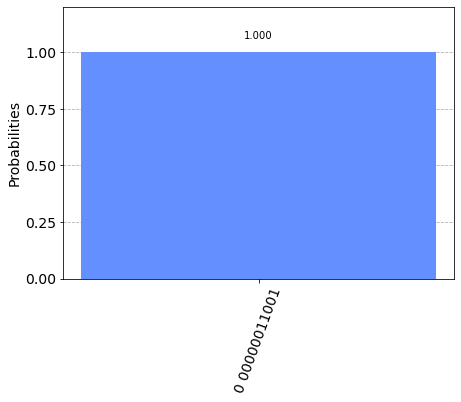

In [169]:
# test run
sim = Aer.get_backend("aer_simulator")
trans_adder = transpile(qc, sim)
result = sim.run(trans_adder, shots=1000).result()
counts = result.get_counts()
print(counts)
plot_histogram(counts)

In [53]:
const = 2
data_qubits = 11

qc = QuantumCircuit(data_qubits)
##############################
### Phase Rotation ###
m = 0
const_b = format(const, f'0{data_qubits}b')
print(f'const_b: {const_b}')

if const:
    for i in range(data_qubits): # i is 0, 1,..,n-1
        for j in range(data_qubits-i): # j in [0,..,data_qubits-1],..,[0]
            # if int(const_b[data_qubits-j-1]): # b='{0}0 000 000 010'
                m = 1/2**(data_qubits-j)
                qc.p(2*math.pi*m, i)
        qc.barrier()
print(qc)

const_b: 00000000010
      ┌───────────┐┌──────────┐┌──────────┐┌──────────┐┌─────────┐┌─────────┐»
 q_0: ┤ P(π/1024) ├┤ P(π/512) ├┤ P(π/256) ├┤ P(π/128) ├┤ P(π/64) ├┤ P(π/32) ├»
      └───────────┘└──────────┘└──────────┘└──────────┘└─────────┘└─────────┘»
 q_1: ───────────────────────────────────────────────────────────────────────»
                                                                             »
 q_2: ───────────────────────────────────────────────────────────────────────»
                                                                             »
 q_3: ───────────────────────────────────────────────────────────────────────»
                                                                             »
 q_4: ───────────────────────────────────────────────────────────────────────»
                                                                             »
 q_5: ───────────────────────────────────────────────────────────────────────»
                               

In [174]:
def solver_function(L1: list, L2: list, C1: list, C2: list, C_max: int) -> QuantumCircuit:
    
    # the number of qubits representing answers
    index_qubits = len(L1)
    
    # the maximum possible total cost
    max_c = sum([max(l0, l1) for l0, l1 in zip(C1, C2)])
    
    # the number of qubits representing data values can be defined using the maximum possible total cost as follows:
    data_qubits = math.ceil(math.log(max_c, 2)) + 1 if not max_c & (max_c - 1) == 0 else math.ceil(math.log(max_c, 2)) + 2
    
    ### Phase Operator ###
    # return part
    def phase_return(index_qubits: int, gamma: float, L1: list, L2: list, to_gate=True) -> Union[Gate, QuantumCircuit]:
        ##############################
        qr_index = QuantumRegister(index_qubits, "index")
        qc = QuantumCircuit(qr_index)

        for i in range(index_qubits):
            qc.rz(gamma*(L2[i]-L1[i]), qr_index[i])
            # qc.barrier()
        # qc.decompose.draw()

        ##############################
        
        return qc.to_gate(label=" phase return ") if to_gate else qc
    
    # penalty part
    def subroutine_add_const(data_qubits: int, const: int, to_gate=True) -> Union[Gate, QuantumCircuit]:
        qc = QuantumCircuit(data_qubits)
        ##############################
        ### Phase Rotation ###
        m = 0
        pre = 1
        if const < 0:
            const = -const
            pre = -1

        const_b = format(const, f'0{data_qubits}b')
        const_b = const_b[::-1]
        # print(f'const_b: {const_b}')    
        # solution 1
        if const:
            for i in range(data_qubits): # i is 0, 1,..,n-1
                for j in range(i+1): # j in [0],..,[0,..,data_qubits-1]
                    if int(const_b[j]): # b='00 000 000 01{0}'
                        m += 1/2**(i-j)
                if (math.pi*m)%(2*math.pi) !=0:
                    qc.p(pre*(math.pi*m)%(2*math.pi), i)
                    m=0
                    #print(f'i: {i}, j in: {data_qubits-i}, m: {m}, const_b: {const_b[data_qubits-j-1]}')
        # solution 2
        # for j in range(data_qubits):
        #     for k in range(data_qubits - j):
        #         lam = math.pi / (2 ** k)
        #         if int(const_b[j]):
        #             qc.p(lam, j+k)
        # print(qc)

        ##############################
        return qc.to_gate(label=" [+"+str(const)+"] ") if to_gate else qc

    # penalty part
    def const_adder(data_qubits: int, const: int, to_gate=True) -> Union[Gate, QuantumCircuit]:
    
        qr_data = QuantumRegister(data_qubits, "data")
        qc = QuantumCircuit(qr_data)

        ##############################
        ### QFT ###
        qc.append(QFT(num_qubits=data_qubits, do_swaps=False).to_gate(), qr_data[:])

        ### Phase Rotation ###
        # Use `subroutine_add_const`
        qc.append(subroutine_add_const(data_qubits=data_qubits, const=const), qr_data[:])

        ### IQFT ###
        qc.append(QFT(num_qubits=data_qubits, inverse=True, do_swaps=False).to_gate(), qr_data[:])

        ##############################
        return qc.to_gate(label=" [ +" + str(const) + "] ") if to_gate else qc 
    
    # penalty part
    def cost_calculation(index_qubits: int, data_qubits: int, list1: list, list2: list, to_gate = True) -> Union[Gate, QuantumCircuit]:
        qr_index = QuantumRegister(index_qubits, "index")
        qr_data = QuantumRegister(data_qubits, "data")
        qc = QuantumCircuit(qr_index, qr_data)

        for i, (val1, val2) in enumerate(zip(list1, list2)):

            ##############################
            ### Add val2 using const_adder controlled by i-th index register (set to 1) ###
            # Provide your code here
            qc.append(const_adder(data_qubits=data_qubits, const=val2).control(), [qr_index[i]] + qr_data[:])

            qc.x(qr_index[i]) # flip control qubit

            ##############################
            ### Add val1 using const_adder controlled by i-th index register (set to 0) ###
            # Provide your code here
            qc.append(const_adder(data_qubits=data_qubits, const=val1).control(), [qr_index[i]] + qr_data[:])

            qc.x(qr_index[i]) # flip control qubit

        return qc.to_gate(label=" Cost Calculation ") if to_gate else qc
    
    # penalty part
    def constraint_testing(data_qubits: int, C_max: int, to_gate = True) -> Union[Gate, QuantumCircuit]:
    
        qr_data = QuantumRegister(data_qubits, "data")
        qr_f = QuantumRegister(1, "flag")
        qc = QuantumCircuit(qr_data, qr_f)

        ##############################
        ### Set the flag register for indices with costs larger than C_max ###
        c = (C_max).bit_length()
        gap = 2**c - C_max
        qc.append(const_adder(data_qubits=data_qubits, const=gap), qr_data[:])
        sub_cir = QuantumCircuit(1)
        sub_cir.x(0)
        qc.append(sub_cir.to_gate().control(num_ctrl_qubits=data_qubits-c, ctrl_state=0), qr_data[c:] + [qr_f[0]])
        # qc.append(const_adder(data_qubits=data_qubits, const=-gap), qr_data[:]) # minus the gap
        qc.x(qr_f[0])
        ##############################

        return qc.to_gate(label=" Constraint Testing ") if to_gate else qc
    
    # penalty part
    def penalty_dephasing(data_qubits: int, alpha: float, gamma: float, to_gate = True) -> Union[Gate, QuantumCircuit]:
    
        qr_data = QuantumRegister(data_qubits, "data")
        qr_f = QuantumRegister(1, "flag")
        qc = QuantumCircuit(qr_data, qr_f)
        c = (max_c).bit_length()

        ##############################
        ### Phase Rotation ###
        # Provide your code here
        for i in range(data_qubits):
            qc.p(alpha*gamma, i)
        qc.p(-(2**c)*alpha*gamma, qr_f[0])

        ##############################

        return qc.to_gate(label=" Penalty Dephasing ") if to_gate else qc
        
    def reinitialization(index_qubits: int, data_qubits: int, C1: list, C2: list, C_max: int, to_gate = True) -> Union[Gate, QuantumCircuit]:
        
        qr_index = QuantumRegister(index_qubits, "index")
        qr_data = QuantumRegister(data_qubits, "data")
        qr_f = QuantumRegister(1, "flag")
        qc = QuantumCircuit(qr_index, qr_data, qr_f)
        
        ##############################
        ### Reinitialization Circuit ###
        # Provide your code here
        qc.append(constraint_testing(data_qubits=data_qubits, C_max=C_max).inverse(), qr_data[:] + qr_f[:])
        qc.append(cost_calculation(index_qubits=index_qubits, data_qubits=data_qubits, list1=C1, list2=C2).inverse(), qr_index[:] + qr_data[:])
        
        
        ##############################
        
        return qc.to_gate(label=" Reinitialization ") if to_gate else qc

    ### Mixing Operator ###
    def mixing_operator(index_qubits: int, beta: float, to_gate = True) -> Union[Gate, QuantumCircuit]:
        
        qr_index = QuantumRegister(index_qubits, "index")
        qc = QuantumCircuit(qr_index)
        
        ##############################
        ### Mixing Operator ###
        # Provide your code here
        for i in range(index_qubits):
            qc.rx(2*beta, qr_index[i])
        
        
        ##############################
        
        return qc.to_gate(label=" Mixing Operator ") if to_gate else qc
    
    qr_index = QuantumRegister(index_qubits, "index") # index register
    qr_data = QuantumRegister(data_qubits, "data") # data register
    qr_f = QuantumRegister(1, "flag") # flag register
    cr_index = ClassicalRegister(index_qubits, "c_index") # classical register storing the measurement result of index register
    qc = QuantumCircuit(qr_index, qr_data, qr_f, cr_index)
    
    ### initialize the index register with uniform superposition state ###
    qc.h(qr_index)
    
    ### DO NOT CHANGE THE CODE BELOW
    p = 5
    alpha = 1
    for i in range(p):
        
        ### set fixed parameters for each round ###
        beta = 1 - (i + 1) / p
        gamma = (i + 1) / p
        
        ### return part ###
        qc.append(phase_return(index_qubits, gamma, L1, L2), qr_index)
        
        ### step 1: cost calculation ###
        qc.append(cost_calculation(index_qubits, data_qubits, C1, C2), qr_index[:] + qr_data[:])
        
        ### step 2: Constraint testing ###
        qc.append(constraint_testing(data_qubits, C_max), qr_data[:] + qr_f[:])
        
        ### step 3: penalty dephasing ###
        qc.append(penalty_dephasing(data_qubits, alpha, gamma), qr_data[:] + qr_f[:])
        
        ### step 4: reinitialization ###
        qc.append(reinitialization(index_qubits, data_qubits, C1, C2, C_max), qr_index[:] + qr_data[:] + qr_f[:])
        
        ### mixing operator ###
        qc.append(mixing_operator(index_qubits, beta), qr_index)

    ### measure the index ###
    ### since the default measurement outcome is shown in big endian, it is necessary to reverse the classical bits in order to unify the endian ###
    qc.measure(qr_index, cr_index[::-1])
    
    return qc

In [176]:
import qc_grader
qc_grader.__version__

'0.8.7'

In [178]:
from qiskit import IBMQ
IBMQ.save_account('5cd4fb14ed1e310399096fe9bd62d528d5999de11ad231bf5e0ca742f7a4e3dd0960a5ddcde760edfbda609b5411e036f45965998ec4993e6336d7b2ed414701')
IBMQ.load_account()
IBMQ.providers()

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='iqc-fall-21-1', group='challenge-2', project='rech3qVe7pj1PiIoe')>]

In [179]:
from qc_grader import prepare_ex4c
job = prepare_ex4c(solver_function)

result = job.result()

Running "solver_function" (1/8)... 
Running "solver_function" (2/8)... 
Running "solver_function" (3/8)... 
Running "solver_function" (4/8)... 
Running "solver_function" (5/8)... 
Running "solver_function" (6/8)... 
Running "solver_function" (7/8)... 
Running "solver_function" (8/8)... 
Starting experiments. Please wait...
You may monitor the job (id: 6183b91e6e4da2fd839b57f2) status and proceed to grading when it successfully completes.


In [180]:
# Check your answer and submit using the following code
from qc_grader import grade_ex4c
grade_ex4c(job)

Submitting your answer for 4c. Please wait...
Oops 😕! Your answer is incorrect
Please review your answer and try again.
